**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2024**

---

### Series Temporales: 
### Introducción a las Series de tiempo (Examen Media Materia)

---

**Integrantes:** Cristian Keimel y Enzo Manolucos
<br>
<br>
<br>

 ## Problema 1:
 
- Objetivo de este problema: Estudiar la demanda mensual de energia electrica en Victoria. 


- Realice los siguientes gráficos siguiendo la notebook **Visualizacion de datos de polucion de corea.ipynb**

    - Gráfico de radar

    - Gráfico de barra circular

    - Gráfico de ploteo radial

 - Diga cual de los trés gráficos provee mejor información visual, y arme una única imagen con todos los gráficos realizados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

In [21]:
plt.style.use('ggplot')
color = sns.color_palette().as_hex()

In [3]:
df = pd.read_csv('../Data/vic_elec.csv')
df.head()

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [5]:
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%dT%H:%M:%SZ')
df.set_index('Time', inplace=True)

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index,
                         y=df['Demand'],
                         mode='lines'
                         ))
fig.update_layout(
    title='Demanda de la energía eléctrica de Victoria, Australia',
    xaxis_title='Tiempo',
    yaxis_title='Demanda [MW]'
    )
fig.show()

## Preparación de datos

Para poder realizar los gráficos se debe crear un nuevo dataframe mediante el método ``.pivot``. Estos nos permite reacomodar los datos de forma tal que los meses serán los indices y las columnas seran los años. Cada valor se completara con el valor medio de la demanda energética de cada mes y año. Para que los gráficos queden lo más completos se debe replicar una nueva fila al final con el valor correspondiente a Enero. También se relleno los valores nulos con 1. Estos valores no seran observables pero ayudaran a poder crear los gráficos

In [7]:
df['Year'] = df.index.year
df['Month'] = df.index.month

In [8]:
df_grouped = df.groupby(['Year', 'Month']).agg({'Demand': 'mean'}).reset_index()
df_pivot = df_grouped.pivot(index='Month', columns='Year', values='Demand')

# Completo con una fila más, con los mismos datos de Enero y relleno los valores nulos con 1
df_pivot.loc[13] = df_pivot.loc[1] 
df_pivot = df_pivot.fillna(1)

In [9]:
months = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

### Gráfico de radar

In [11]:
fig = go.Figure()

for year in df_pivot.columns:
    fig.add_trace(go.Scatterpolar(
        name = str(year),
        r = df_pivot[year],
        theta = months + ['Enero'], 
        #mode='lines',
        #fill='toself',
        #fillcolor=None
        ))

fig.update_layout(polar = dict(radialaxis_title="Demanda [MW]",
                               radialaxis = dict(visible = True, range=[4200, 5200]),
                               angularaxis = dict(rotation=-90)),
                    title='Demanda de la Energía Eléctrica por Mes (Polar)',
                  showlegend=True, 
                  width=720, 
                  height=720)
fig.show()

### Gráfico de barra circular

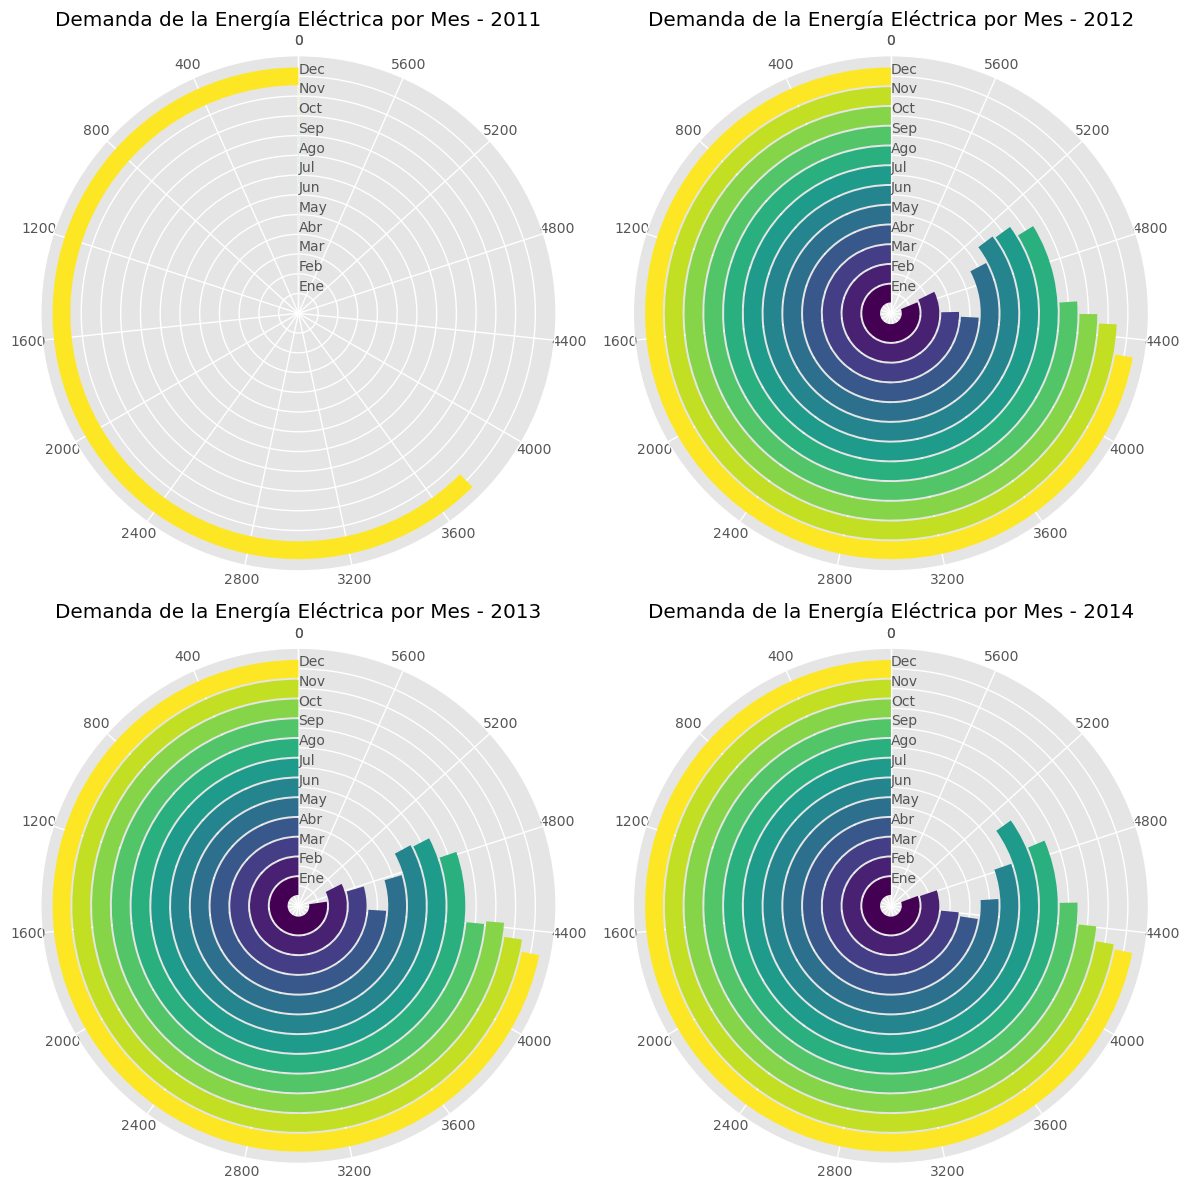

In [118]:
labels = [0, 400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000, 4400, 4800, 5200, 5600, 0]
cmap = plt.get_cmap('viridis')  # Obtener la paleta 'viridis'
max_value = 6000

fig, axs = plt.subplots(2, 2, figsize=(12, 12), subplot_kw={'projection': 'polar'})
axs = axs.flatten()

for idx, (year, ax) in enumerate(zip(df_pivot.columns, axs)):
    for i in range(12):  
        value = df_pivot[year].loc[i + 1]
        color = cmap(i / 11)  
        ax.barh(i + 1, value * 2 * np.pi / max_value, height=0.9, color=color)

    ax.set_theta_zero_location('N')  
    ax.set_theta_direction(1)        
    ax.set_rlabel_position(0)        
    ax.set_rgrids(range(1, 13), labels=months) 
    ax.set_title(f'Demanda de la Energía Eléctrica por Mes - {year}')
    ax.set_thetagrids(range(0, 384, 24), labels=labels)

plt.tight_layout()
plt.show()


### Gráfico de ploteo radial

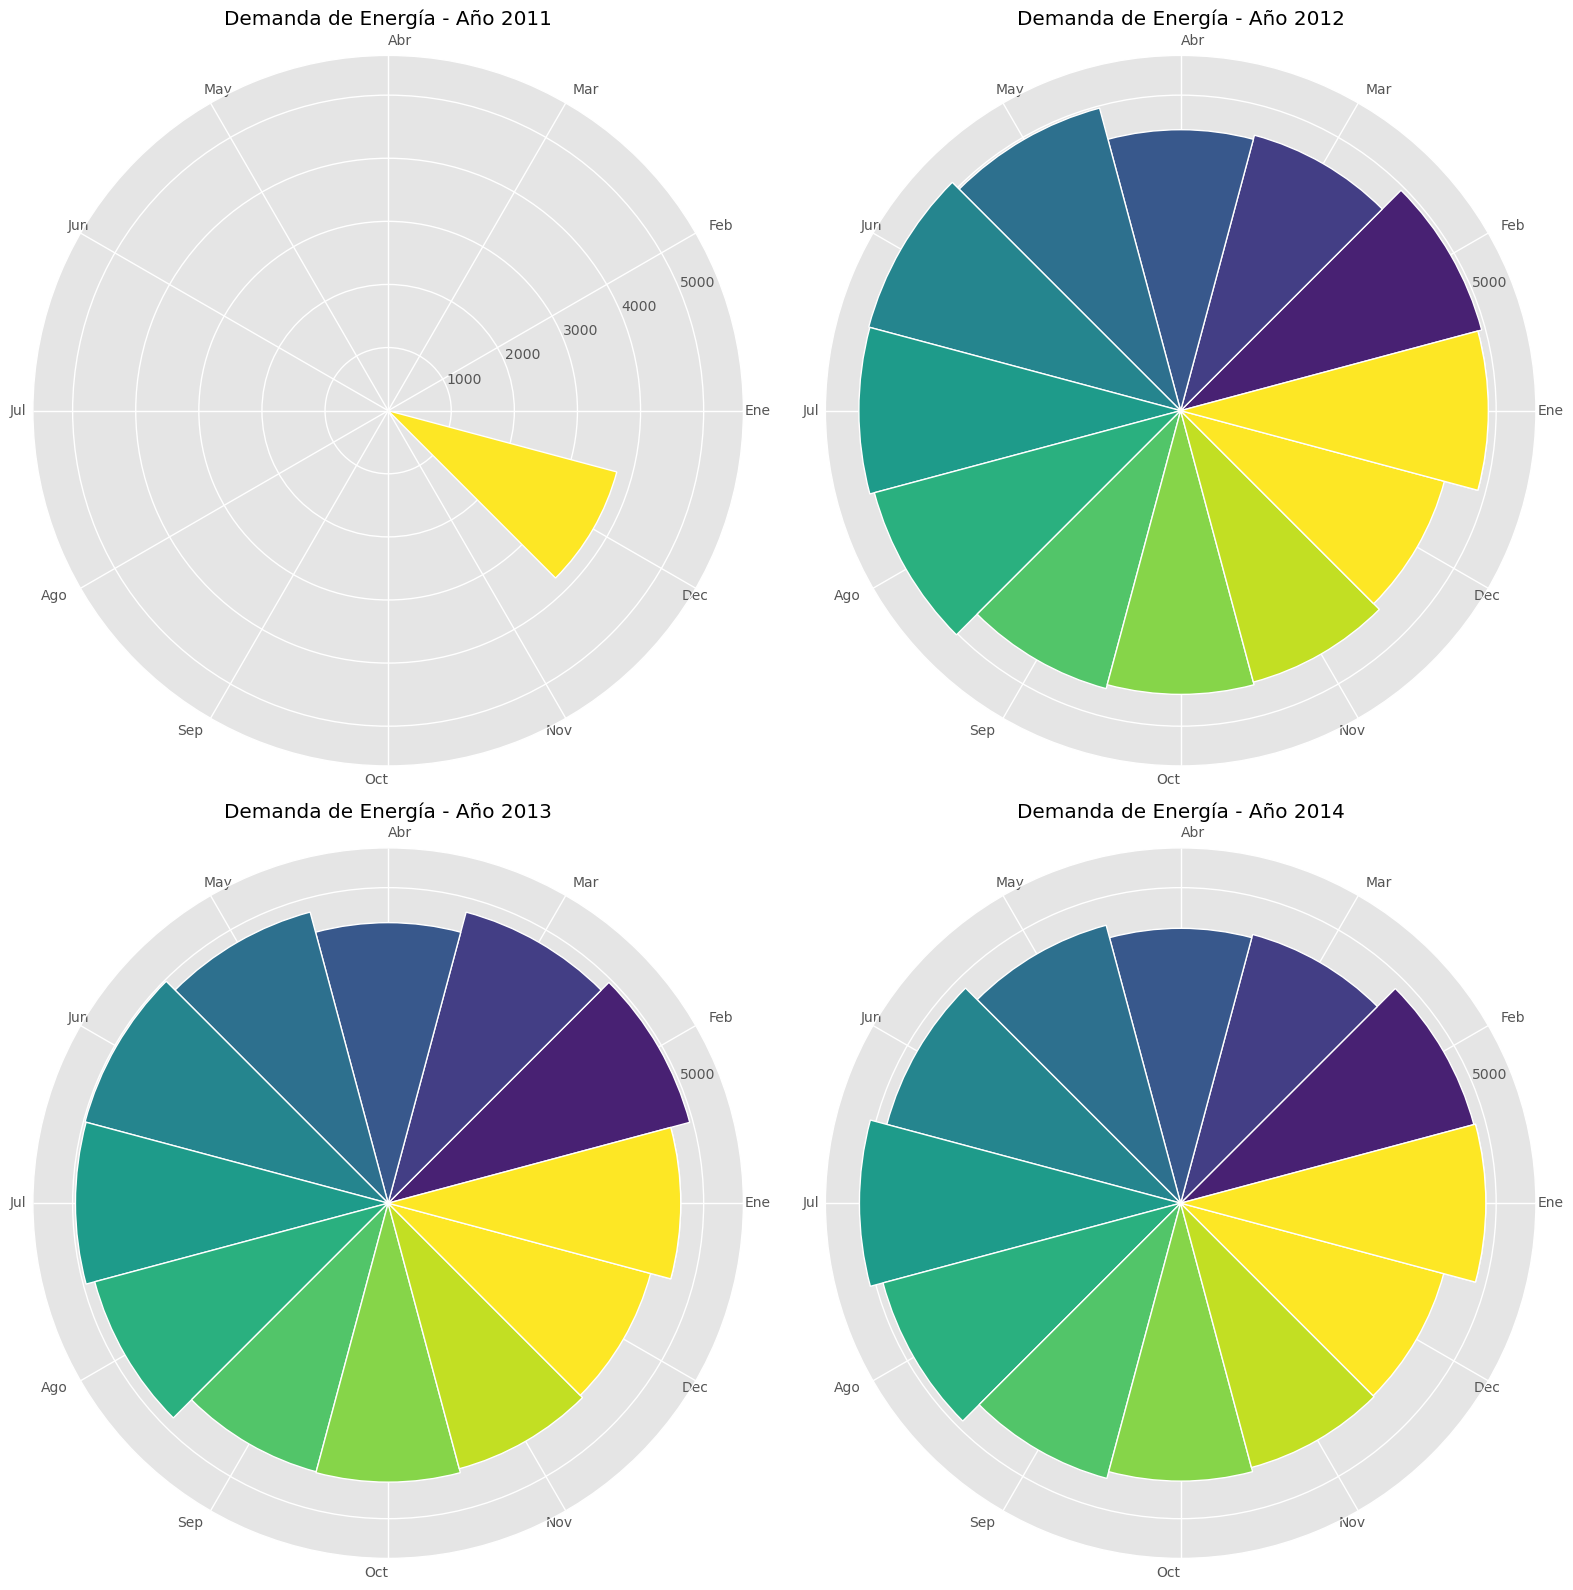

In [120]:
cmap = plt.get_cmap('viridis')
max_value = df_pivot.max().max()

fig, axs = plt.subplots(2, 2, figsize=(16, 16), subplot_kw=dict(projection='polar'))
axs = axs.flatten()

for idx, (year, ax) in enumerate(zip(df_pivot.columns, axs)):
    values = df_pivot[year].drop(13, errors='ignore')
    angles = np.linspace(0, 2 * np.pi, len(months), endpoint=False).tolist()
    angles += angles[:1]  # Completar el círculo
    values = values.tolist()
    values += values[:1]  # Completar el círculo

    width = 2 * np.pi / len(months)  # Ancho de las barras
    lowerLimit = 0  # Límite inferior para las barras

    bars = ax.bar(angles, values, width=width, align='center', bottom=lowerLimit, linewidth=1, edgecolor="white")

    for i, bar in enumerate(bars):
        bar.set_facecolor(cmap(i / (len(months) - 1)))  # Color basado en el índice del mes

    ax.set_ylim(0, max_value * 1.1)  # 10% más que el valor máximo global
    ax.set_xticks(angles[:-1])  # No incluir el último ángulo duplicado en los ticks
    ax.set_xticklabels(months, fontsize=10)

    for label, angle in zip(ax.get_xticklabels(), angles[:-1]):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    ax.set_title(f'Demanda de Energía - Año {year}')

plt.tight_layout()
plt.show()


## Problema 2:
 
- Objetivo de este problema: Realizar descomposiciones en tendencia y estacionalidad aditiva y multiplicativa (seasonal_decompose) para los gases de madrid 'NO_2' y 'CO'.  

- Dar una opinion de lo observado.

## Problema 3:
 
- Objetivo de este problema: Realizar suavizado exponencial, suavizado de Holt y suavizado de Holt-Winter  para los gases de madrid 'NO_2' y 'CO'. 

- Encontrar los parámetros generando un set de validación y MSE. 

- Predecir usando TODA la serie (train mas validacion) y comparar con TEST . 

- Plotear la serie completa y la prediccion para observar el comportamiento de cada uno de los suavizados.

- Dar una opinion de la bondad del método para estas series. 